In [161]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [162]:
import zipfile
zip = zipfile.ZipFile("/content/gdrive/My Drive/821469_1405070_bundle_archive.zip", 'r')
zip.extractall("X_ray_dataset")
zip.close()
print("extractzipfile")

extractzipfile


In [163]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

In [164]:
#Declaring the image size and the train, test path of the dataset
# Resizinig all the images to (224,224)
IMAGE_SIZE = [224,224]

train_path = '/content/X_ray_dataset/covid_update/Train'
test_path = '/content/X_ray_dataset/covid_update/Test'


#In this we will be using ResNet-50 Pretrained Moldel


In [165]:
resnet = ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [166]:
#Now we dont have to train the existing weights we just have to train our last layer.
for layer in resnet.layers:
  layer.trainable = False

In [167]:
#By using the Glob function we will be able to know our output classes.
folder = glob('/content/X_ray_dataset/covid_update/*')
folder

['/content/X_ray_dataset/covid_update/Train',
 '/content/X_ray_dataset/covid_update/Test']

In [168]:
len(folder)

2

In [169]:
#Now the next we need to Flatten our ResNet model.
#What is Flattening of layer, why is it required?
###We need to convert our 2D features to 1D features. Flatting is required when we have to convert our layer to a fully connected layer.

x = Flatten()(resnet.output)

In [170]:
#Adding our last laye
prediction = Dense(2, activation='softmax')(x)

In [171]:
model = Model(inputs = resnet.inputs, outputs = prediction)

In [172]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [173]:
#Compiling our model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#The Data Augmentation 


In [174]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [175]:
# flow_from_directory means i am applying all the train_datagen techniques to all the images
# We need to provide the same traget_size as initialized in the IMAGE_SIZE
# If you have more than two classes we should use class_mode = categorical
# But if we have just two classses we can use class_mode = binary

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode = 'categorical')

Found 453 images belonging to 2 classes.


In [176]:
# Applying the same techniques on the test dataset

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 219 images belonging to 2 classes.


#Training our model

In [177]:
EarlyStopping = EarlyStopping(monitor='val_loss', patience=5 , mode='min', verbose=1)

In [178]:
history = model.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set), callbacks=EarlyStopping)

Epoch 1/50
15/15 [==============================] - 19s 1s/step - loss: 3.3855 - accuracy: 0.5342 - val_loss: 1.2110 - val_accuracy: 0.5434
Epoch 2/50
15/15 [==============================] - 18s 1s/step - loss: 0.9842 - accuracy: 0.5695 - val_loss: 0.9565 - val_accuracy: 0.5479
Epoch 3/50
15/15 [==============================] - 18s 1s/step - loss: 0.4806 - accuracy: 0.7903 - val_loss: 0.5374 - val_accuracy: 0.7306
Epoch 4/50
15/15 [==============================] - 18s 1s/step - loss: 0.3213 - accuracy: 0.8587 - val_loss: 0.4676 - val_accuracy: 0.7808
Epoch 5/50
15/15 [==============================] - 18s 1s/step - loss: 0.3153 - accuracy: 0.8587 - val_loss: 0.5031 - val_accuracy: 0.7626
Epoch 6/50
15/15 [==============================] - 18s 1s/step - loss: 0.2895 - accuracy: 0.8962 - val_loss: 0.4248 - val_accuracy: 0.7991
Epoch 7/50
15/15 [==============================] - 18s 1s/step - loss: 0.2790 - accuracy: 0.9007 - val_loss: 0.4229 - val_accuracy: 0.8037
Epoch 8/50
15/15 [==

In [194]:
#Plotting the losses and Accuracy on the dataset


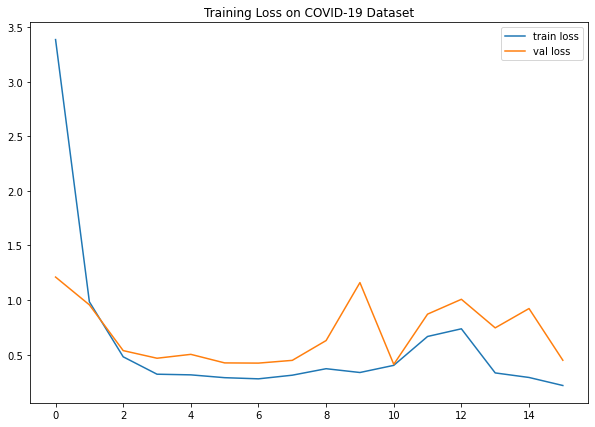

In [195]:
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Training Loss on COVID-19 Dataset")
plt.legend()
plt.show()

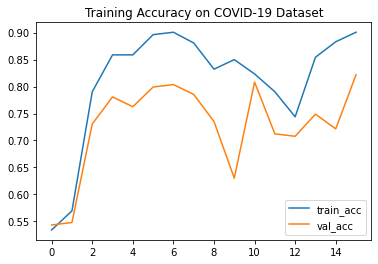

<Figure size 432x288 with 0 Axes>

In [196]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Training Accuracy on COVID-19 Dataset")
plt.legend()
plt.show()
plt.savefig('lossval_loss')

In [197]:
#Saving the h5 file
from tensorflow.keras.models import load_model

model.save('covid_chest_xray_model.h5')

#Predicting our model

In [198]:
pred = model.predict(test_set)
pred

array([[8.11414361e-01, 1.88585669e-01],
       [9.29138422e-01, 7.08616078e-02],
       [1.95472836e-01, 8.04527223e-01],
       [4.03527496e-03, 9.95964766e-01],
       [9.97156620e-01, 2.84336251e-03],
       [3.54752530e-08, 1.00000000e+00],
       [9.67052281e-01, 3.29477638e-02],
       [1.10424578e-01, 8.89575422e-01],
       [5.60500324e-01, 4.39499706e-01],
       [7.33474270e-04, 9.99266565e-01],
       [6.70500938e-03, 9.93295014e-01],
       [1.72570720e-01, 8.27429295e-01],
       [1.44648610e-03, 9.98553455e-01],
       [1.27848771e-05, 9.99987245e-01],
       [4.28430676e-01, 5.71569383e-01],
       [6.95282102e-01, 3.04717869e-01],
       [8.31275899e-03, 9.91687238e-01],
       [9.70418632e-01, 2.95813773e-02],
       [9.04629007e-02, 9.09537137e-01],
       [9.78490174e-01, 2.15097815e-02],
       [9.86316502e-01, 1.36835445e-02],
       [3.09075236e-01, 6.90924764e-01],
       [7.03220212e-06, 9.99992967e-01],
       [6.55554950e-01, 3.44445080e-01],
       [2.067139

In [199]:
import numpy as np

pred = np.argmax(pred, axis=0)
pred

array([71,  5])

In [200]:
#Loading our model¶

model = load_model('covid_chest_xray_model.h5')

In [209]:
from tensorflow.keras.preprocessing import image

img = image.load_img('/content/X_ray_dataset/covid_update/Test/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg', target_size=(224,224))

In [210]:
x = image.img_to_array(img)
x

array([[[ 44.,  42.,  43.],
        [ 53.,  51.,  52.],
        [ 57.,  55.,  56.],
        ...,
        [ 92.,  92.,  92.],
        [ 73.,  73.,  73.],
        [ 54.,  52.,  55.]],

       [[ 54.,  52.,  53.],
        [ 57.,  55.,  56.],
        [ 60.,  58.,  59.],
        ...,
        [ 67.,  65.,  68.],
        [ 71.,  69.,  72.],
        [ 74.,  74.,  76.]],

       [[ 55.,  53.,  56.],
        [ 56.,  56.,  58.],
        [ 59.,  59.,  59.],
        ...,
        [ 92.,  92.,  94.],
        [ 62.,  62.,  64.],
        [ 46.,  44.,  47.]],

       ...,

       [[ 67.,  67.,  69.],
        [ 73.,  73.,  75.],
        [ 70.,  70.,  72.],
        ...,
        [ 67.,  67.,  69.],
        [ 89.,  89.,  91.],
        [ 89.,  89.,  91.]],

       [[ 80.,  80.,  82.],
        [ 74.,  74.,  76.],
        [ 70.,  70.,  72.],
        ...,
        [ 72.,  72.,  74.],
        [ 87.,  87.,  89.],
        [ 93.,  93.,  95.]],

       [[ 78.,  78.,  78.],
        [ 61.,  61.,  63.],
        [ 68.,  

In [211]:
x.shape

(224, 224, 3)

In [212]:
x = x/255

In [213]:

from tensorflow.keras.applications.resnet50 import preprocess_input

x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [214]:
model.predict(img_data)

array([[1.000000e+00, 2.913577e-23]], dtype=float32)

In [215]:
a=np.argmax(model.predict(img_data), axis=1)

In [216]:
if(a==1):
    print("The person does not have COVID-19")
else:
    print("The person has COVID-19")


The person has COVID-19
